# Prequential Evaluation capyMOA

Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Umma,ed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos e preenchendo valores nulos...
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 83) ---
Variância: 16 features removidas. Restantes: 67
Correlação (>0.95): 33 features redundantes removidas. Restantes: 34
Random Forest: Pular.
Features Finais (34) - ['Source Port_Entropy', 'Destination Port_Entropy', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Mean', 'Bwd IAT Mean', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Bwd Packe

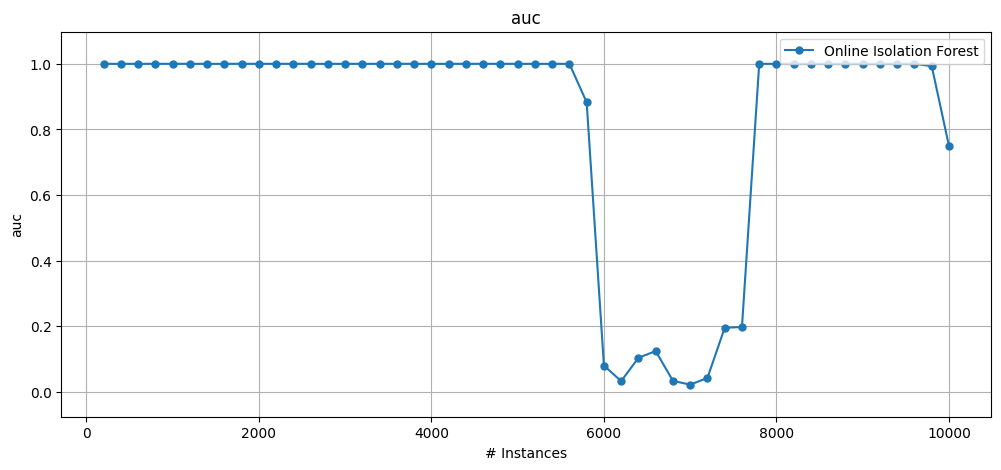

In [ ]:
from capymoa.anomaly import OnlineIsolationForest
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.evaluation import prequential_evaluation_anomaly
from py.DataStreamProcessor import DataStreamProcessor
import pandas as pd

INICIO = 0
FIM = 10000
TOTAL_AMOSTRAS = FIM - INICIO
MAX_INSTANCES = TOTAL_AMOSTRAS

df = pd.read_csv(
    'datasets/CICDDoS2019/data/Exp_janela/SNMP_DNS_1s_0112.csv', 
    skiprows=range(1, INICIO), 
    nrows=TOTAL_AMOSTRAS
)

processor = DataStreamProcessor(logging=True)

stream, targets, features = processor.create_stream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.75,
    threshold_corr=0.95,
    top_n_features=None,
    stream=True
)

oif = OnlineIsolationForest(schema=stream.get_schema())

results_oif = prequential_evaluation_anomaly(
    stream=stream, learner=oif, window_size=200
)

print(f"AUC: {results_oif.auc()}")
# display(results_oif.windowed.metrics_per_window())
plot_windowed_results(results_oif, metric="auc", save_only=False)

# Execução Pipelines

## Resultados CICDDoS2019

### Consistência

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Unnamed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos...
Tratamento de Nulos: Preenchendo com a MEDIANA das colunas...
Normalização: StandardScaler
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 78) ---
Variância: 12 features removidas. Restantes: 66
Correlação (>0.85): 31 features redundantes removidas. Restantes: 35
Random Forest: Top 15 selecionadas.
Features Finais (15) - ['Fwd Packet Length Min', 'Packet Length Mean', 'Fwd Packet Length Max', 'Fwd Header Length', 'Inbound', 'Total Length of Fwd Packets', 'Flow Duration', 'Init_Win_bytes_forward', 'URG Flag Count', 'Fwd Packets/s', 'Flow IAT Std', 'Fwd Packet Length Std', 'Total Backward Packets', 'Flow IAT Min'

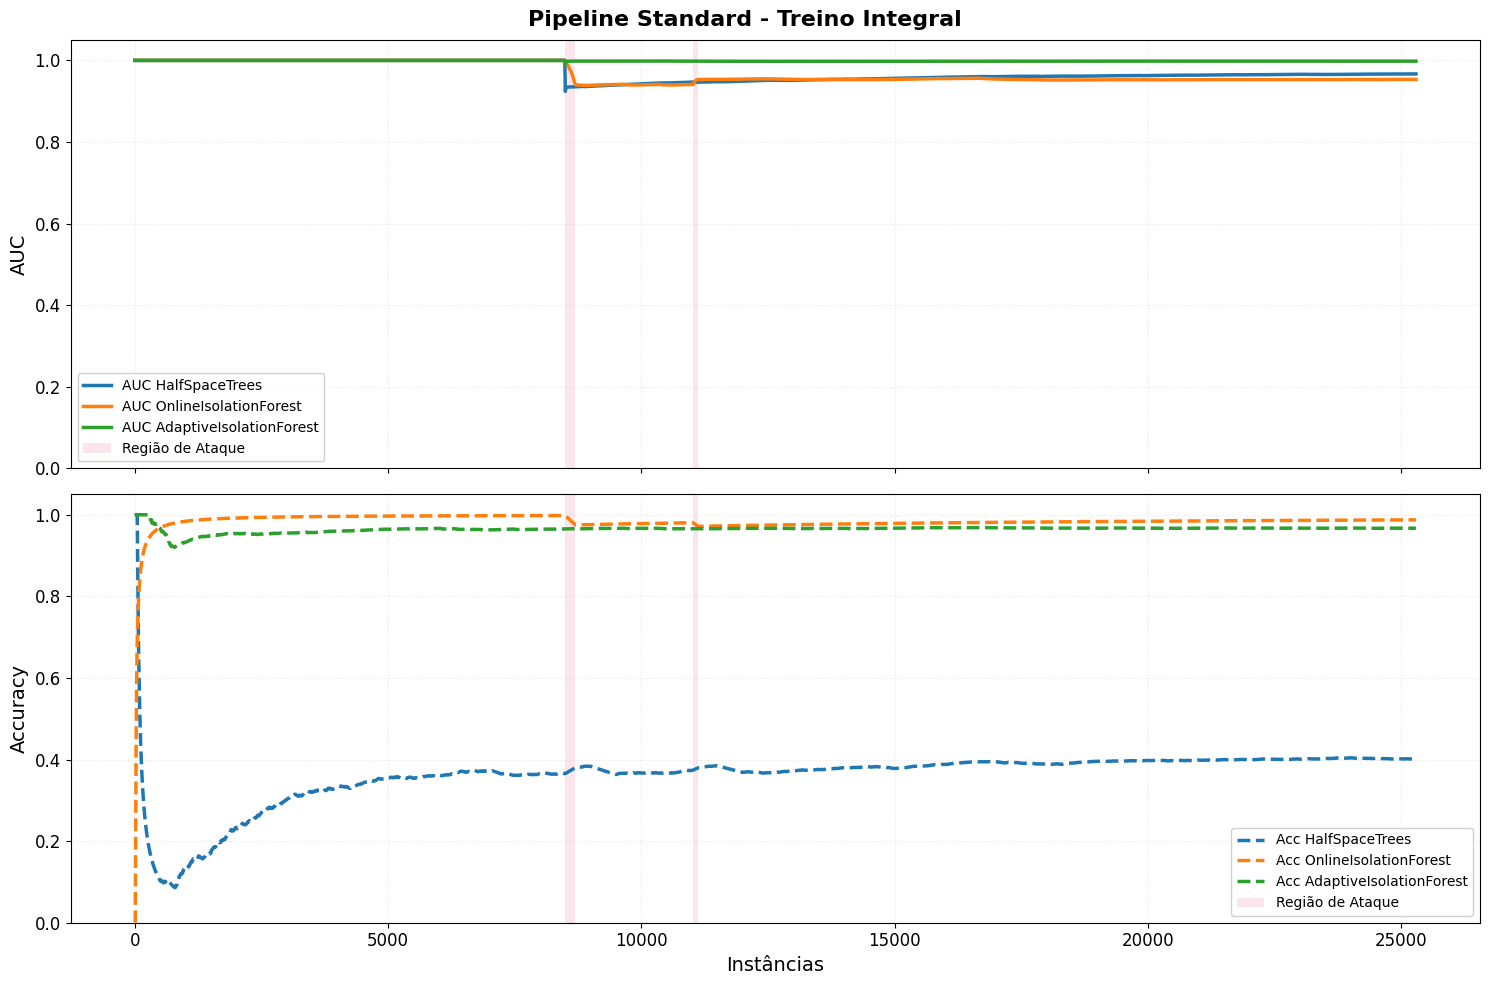

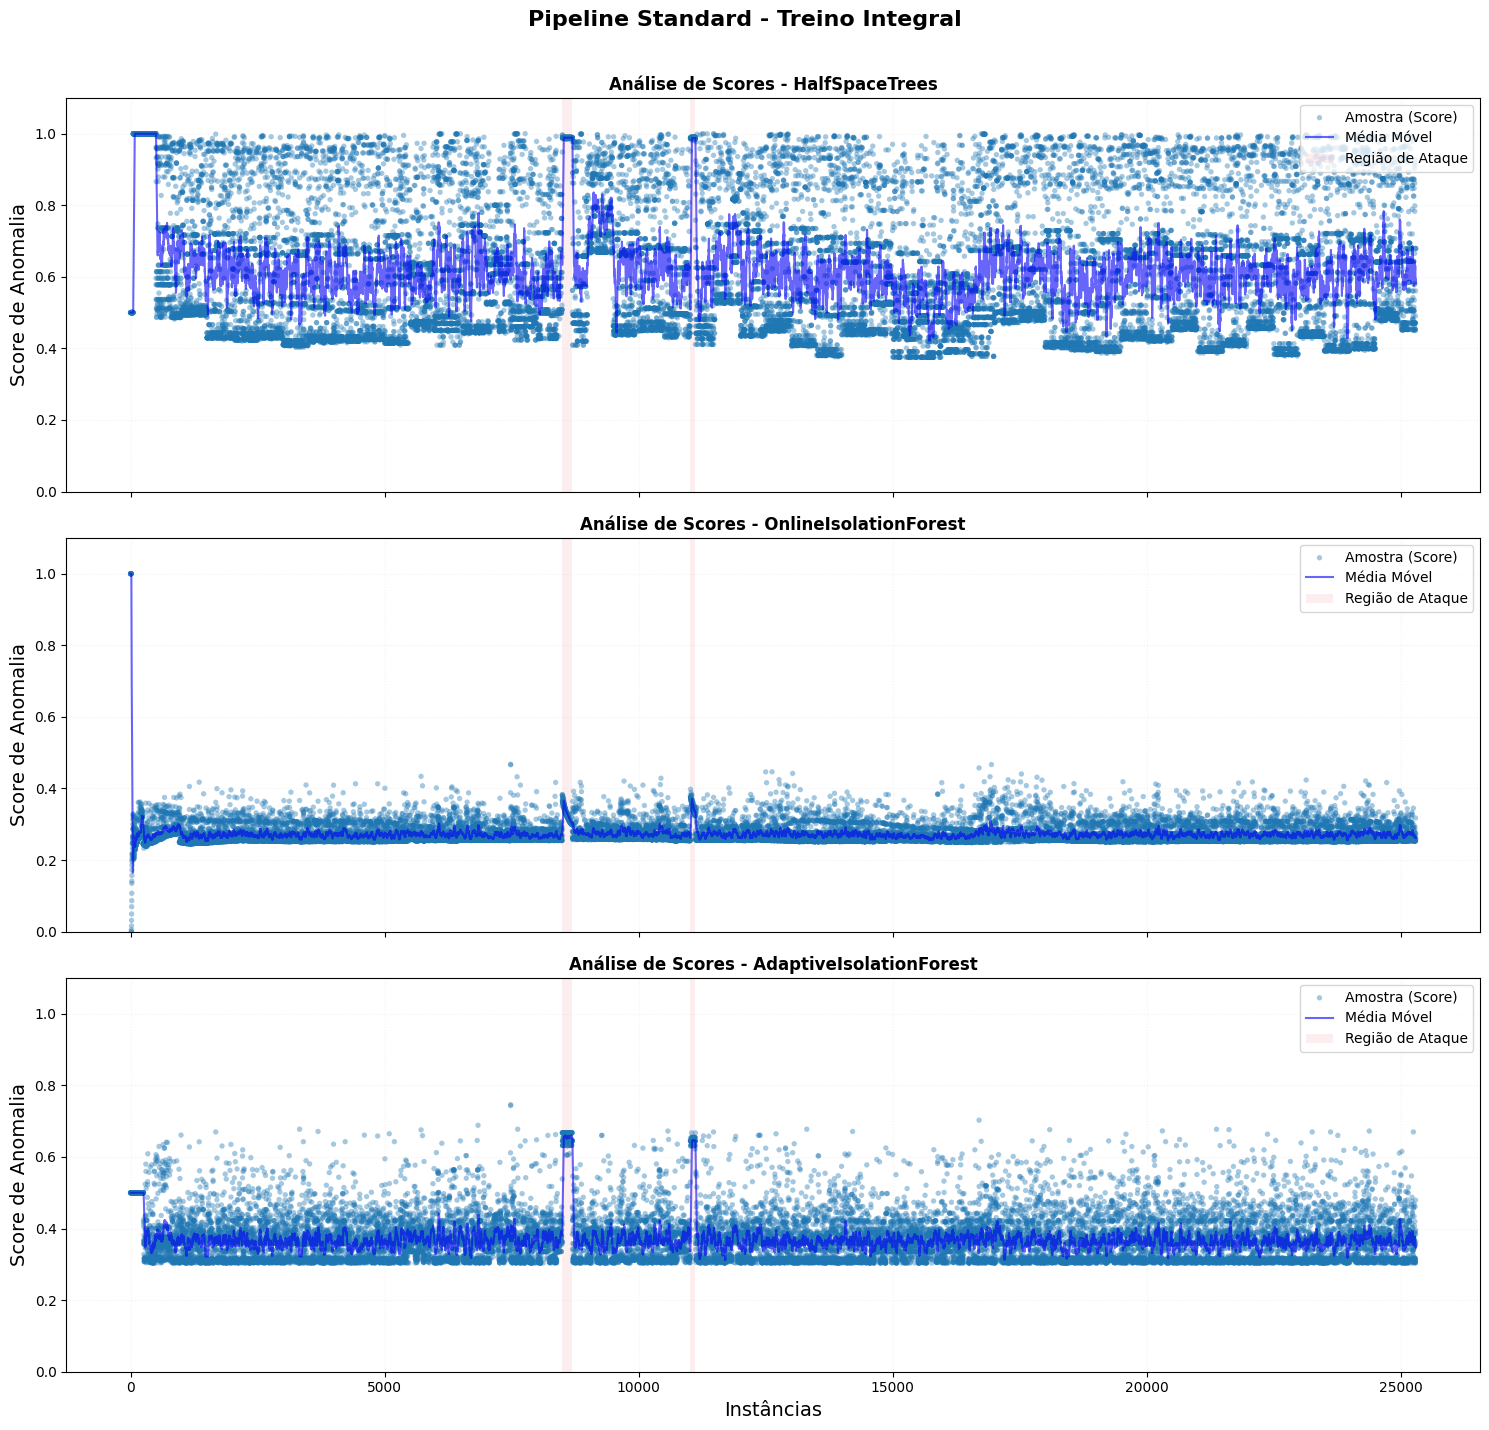

In [4]:
%load_ext autoreload
%autoreload 2

from py.AnomalyDetectionPipeline import AnomalyExperimentRunner
from py.AnomalyDetectionModels import get_anomaly_models
from py.DataStreamProcessor import DataStreamProcessor
import pandas as pd

# Instancia o objeto
processor = DataStreamProcessor(logging=True)
runner = AnomalyExperimentRunner()

df = pd.read_csv('datasets/CICDDoS2019/data/01-12/AnomalyDetection/MSSQL_SSDP.csv')

stream, targets, features = processor.create_stream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="StandardScaler", 
    threshold_var=0.001,
    threshold_corr=0.85,
    top_n_features=15,
    return_stream=True,
    extra_ignore_cols=['Source IP', 'Source Port','Destination IP','Destination Port','Protocol'],
    imputation_method='mediana'
)

# Configurar seus algoritmos 
algoritmos = get_anomaly_models(
    stream.get_schema(), 
    selected_models=['AIF','OIF', 'HST'],
    oif_params={'random_seed': 1,
                'num_trees': 32,
                'max_leaf_samples': 15,
                'growth_criterion': 'adaptive', # 'fixed' or 'adaptive'
                'subsample': 1.0,
                'window_size': 2048,
                'branching_factor': 2,
                'split': 'axisparallel',
                'n_jobs': 1},
    aif_params={'window_size': 256,
                'n_trees': 100,
                'height': None,
                'seed': 1, # int or None
                'm_trees': 10,
                'weights': 0.5},
    hst_params={'CLI': None,
                'random_seed': 1,
                'window_size': 500,
                'number_of_trees': 32,
                'max_depth': 10,
                'anomaly_threshold': 0.5,
                'size_limit': 0.1}
)

# Pipeline Padrão 
runner.ExecuteExperiments(
    stream=stream, 
    pipeline_name='standard', 
    algorithms=algoritmos,
    window_size=10, 
    title="Pipeline Standard - Treino Integral"
)

### Generalização

Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Unnamed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos...
Tratamento de Nulos: Preenchendo com a MEDIANA das colunas...
Normalização: MinMaxScaler
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 78) ---
Variância: 33 features removidas. Restantes: 45
Correlação (>0.8): 24 features redundantes removidas. Restantes: 21
Random Forest: Pular.
Features Finais (21) - ['Flow Duration', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow IAT Std', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'SYN Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'Down/Up Ratio', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward', 'Active

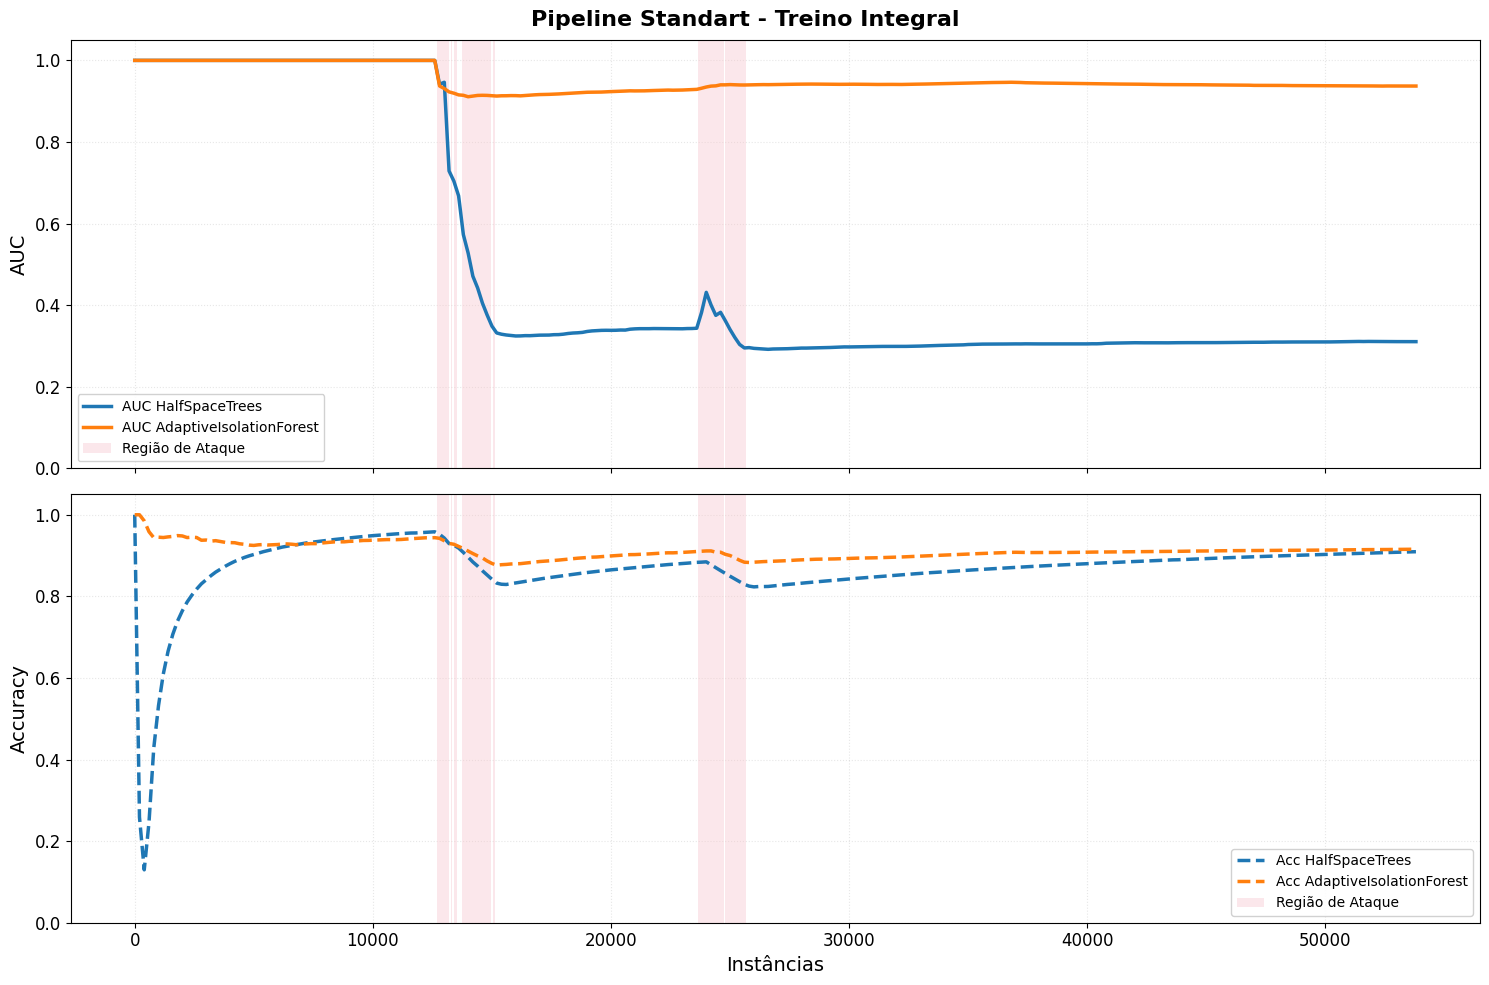

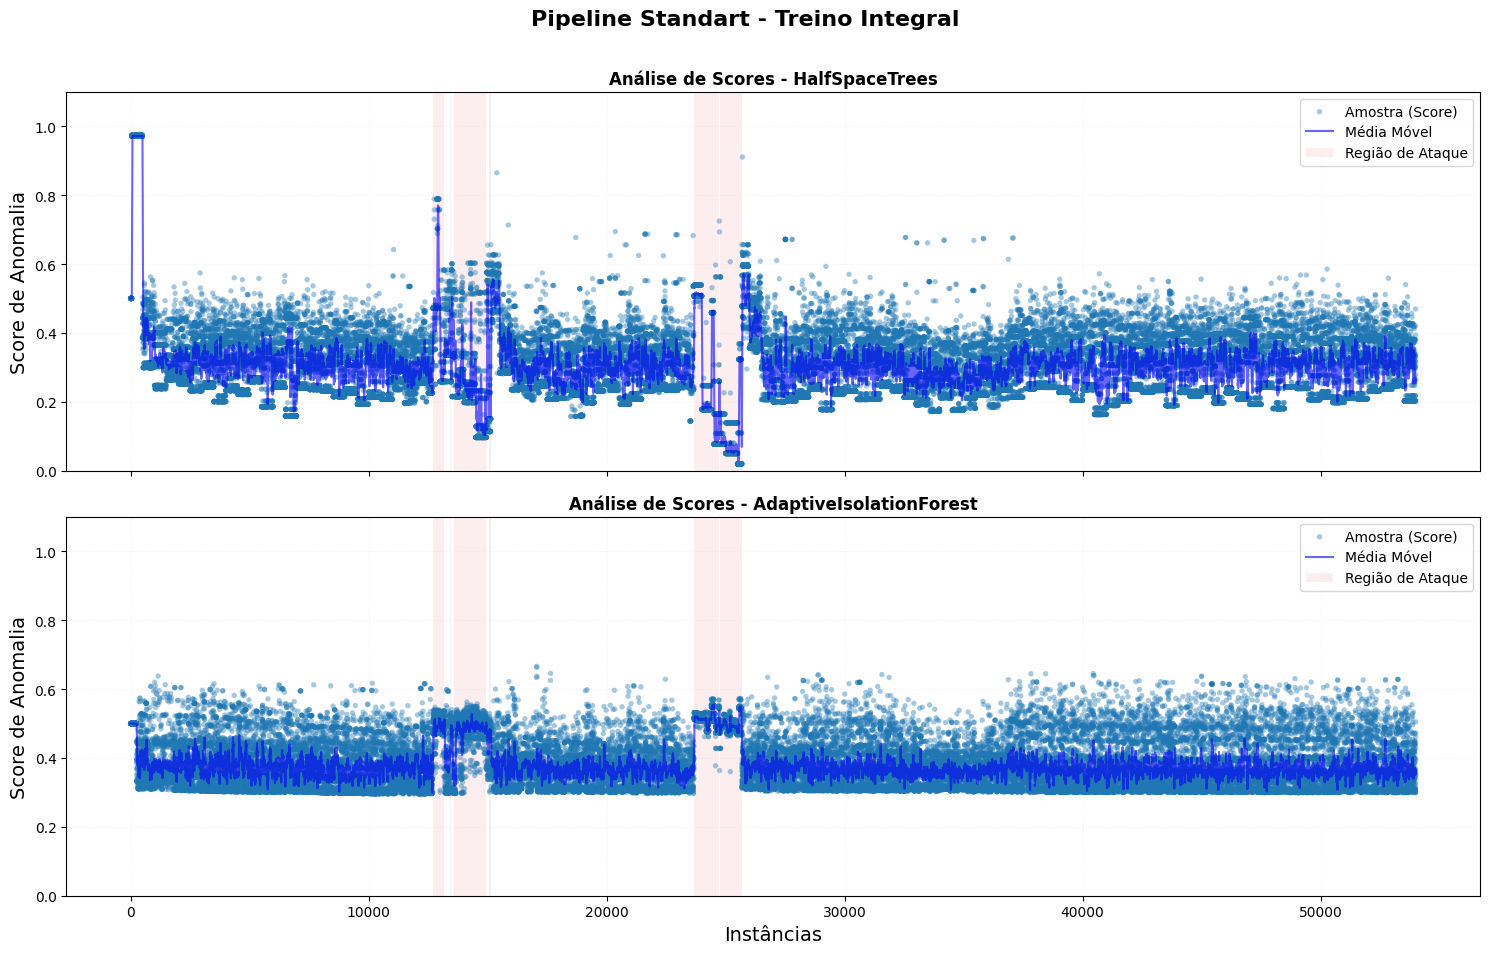

In [2]:
from py.AnomalyDetectionPipeline import AnomalyExperimentRunner
from py.AnomalyDetectionModels import get_anomaly_models
from py.DataStreamProcessor import DataStreamProcessor
import pandas as pd

# Instancia o objeto
processor = DataStreamProcessor(logging=True)
runner = AnomalyExperimentRunner()

df = pd.read_csv('datasets/CICDDoS2019/data/01-12/AnomalyDetection/DNS_SSDP.csv')

stream, targets, features = processor.create_stream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.001,
    threshold_corr=0.80,
    top_n_features=None,
    return_stream=True,
    extra_ignore_cols=['Source IP', 'Source Port','Destination IP','Destination Port','Protocol'],
    imputation_method='mediana'
)


# Configurar seus algoritmos 
algoritmos = get_anomaly_models(
    stream.get_schema(), 
    selected_models=['HST', 'AIF']
)

# Pipeline Padrão 
runner.ExecuteExperiments(
    stream=stream, 
    pipeline_name='standard', 
    algorithms=algoritmos,
    window_size=200, 
    title="Pipeline Standart - Treino Integral"
)

### Adaptação

Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Unnamed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos...
Tratamento de Nulos: Preenchendo com a MEDIANA das colunas...
Normalização: MinMaxScaler
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 78) ---
Variância: 32 features removidas. Restantes: 46
Correlação (>0.8): 22 features redundantes removidas. Restantes: 24
Random Forest: Pular.
Features Finais (24) - ['Flow Duration', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Bwd IAT Std', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Packet Length Mean', 'SYN Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'Down/Up Ratio', 'Init_Win_bytes_forward', 'I

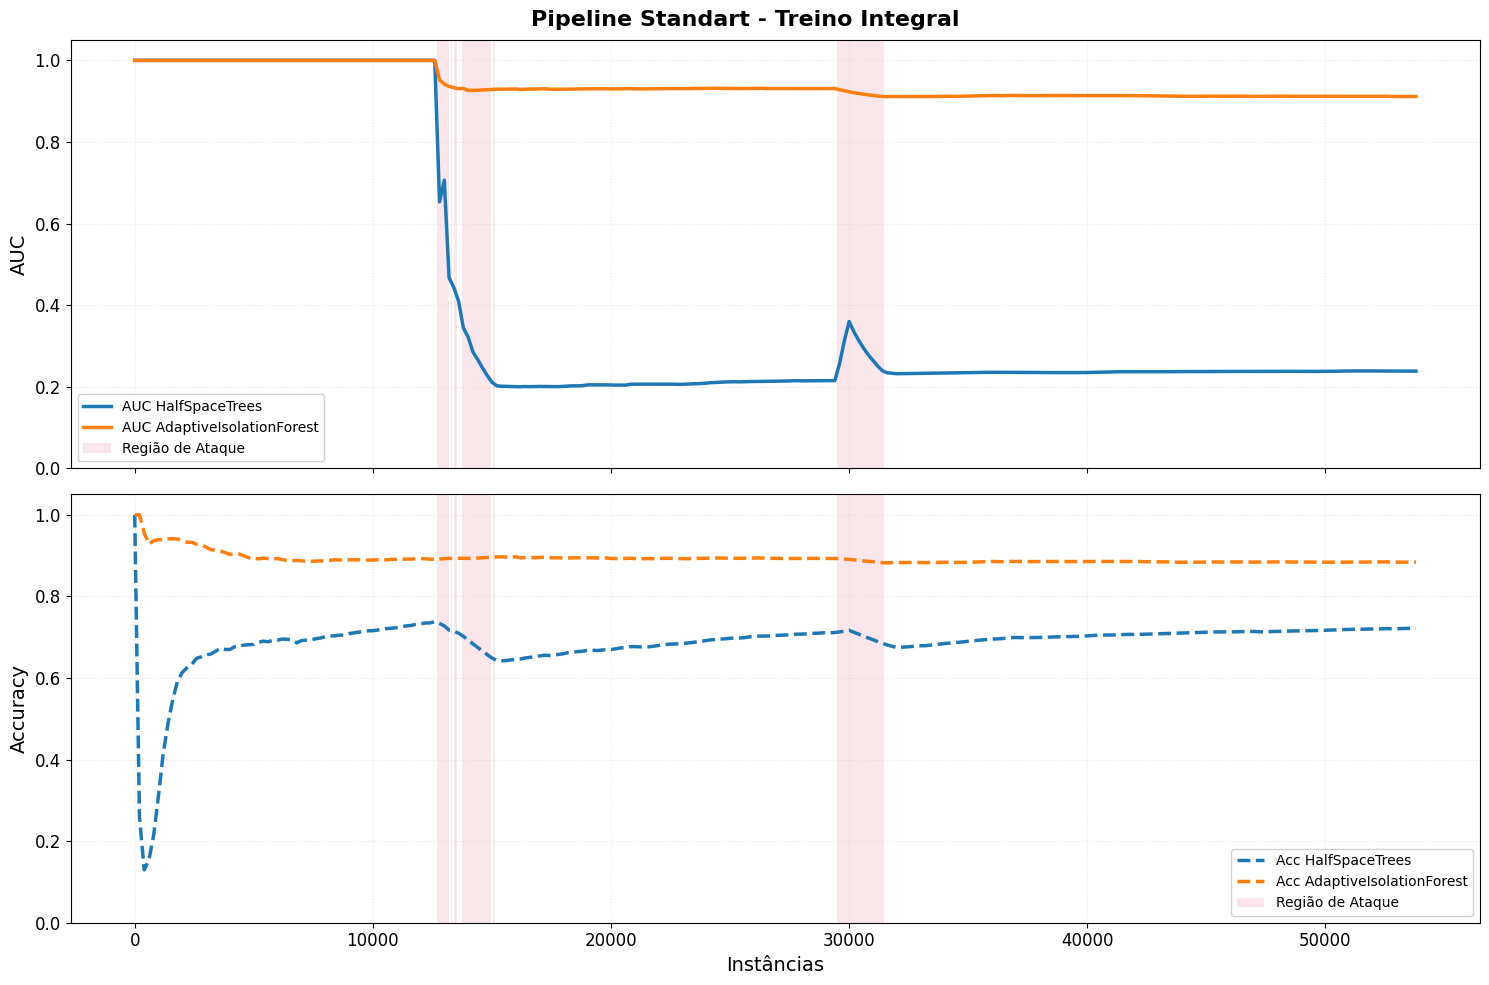

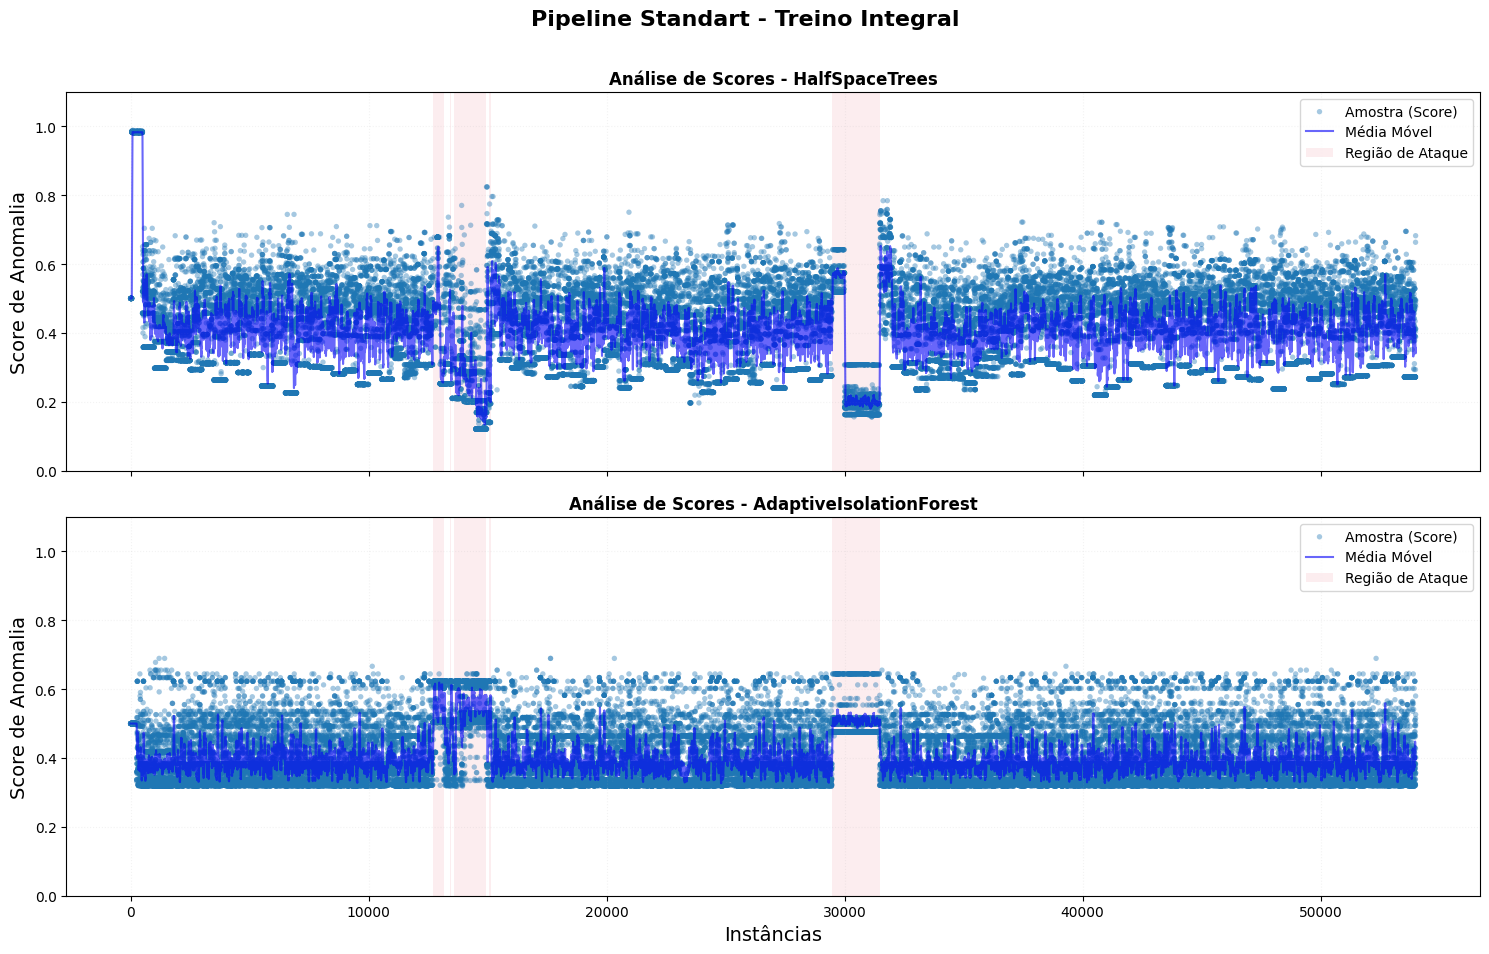

In [4]:
from py.AnomalyDetectionPipeline import AnomalyExperimentRunner
from py.AnomalyDetectionModels import get_anomaly_models
from py.DataStreamProcessor import DataStreamProcessor
import pandas as pd

# Instancia o objeto
processor = DataStreamProcessor(logging=True)
runner = AnomalyExperimentRunner()

df = pd.read_csv('datasets/CICDDoS2019/data/01-12/AnomalyDetection/DNS_Syn.csv')

stream, targets, features = processor.create_stream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.001,
    threshold_corr=0.80,
    top_n_features=None,
    return_stream=True,
    extra_ignore_cols=['Source IP', 'Source Port','Destination IP','Destination Port','Protocol'],
    imputation_method='mediana'
)


# Configurar seus algoritmos 
algoritmos = get_anomaly_models(
    stream.get_schema(), 
    selected_models=['HST', 'AIF']
)

# Pipeline Padrão 
runner.ExecuteExperiments(
    stream=stream, 
    pipeline_name='standard', 
    algorithms=algoritmos,
    window_size=200, 
    title="Pipeline Standart - Treino Integral"
)

## Resultados CIC-IDS-2017

### Constistência

Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Unnamed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos...
Tratamento de Nulos: Preenchendo com a MEDIANA das colunas...
Normalização: MinMaxScaler
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 77) ---
Variância: 40 features removidas. Restantes: 37
Correlação (>0.8): 22 features redundantes removidas. Restantes: 15
Random Forest: Pular.
Features Finais (15) - ['Flow Duration', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Flow IAT Mean', 'Fwd IAT Std', 'Fwd PSH Flags', 'Fwd Packets/s', 'FIN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward', 'Idle Std']
--- Fim do Processo de Seleção de Features ---

Finalização: Criando objeto NumpyStream para o CapyMOA.



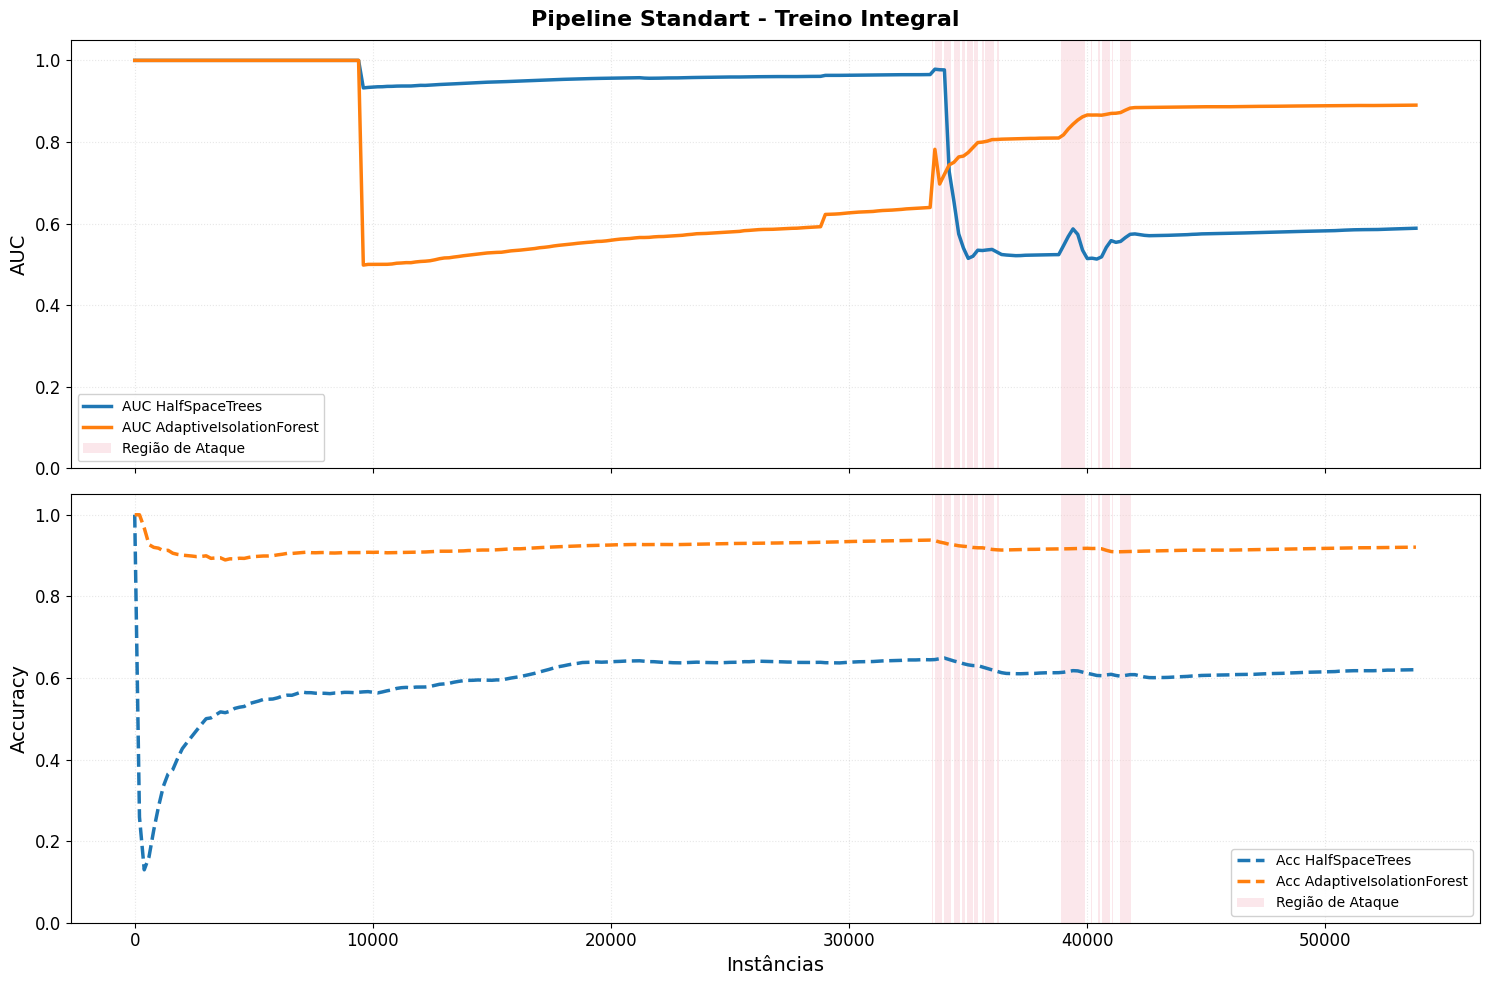

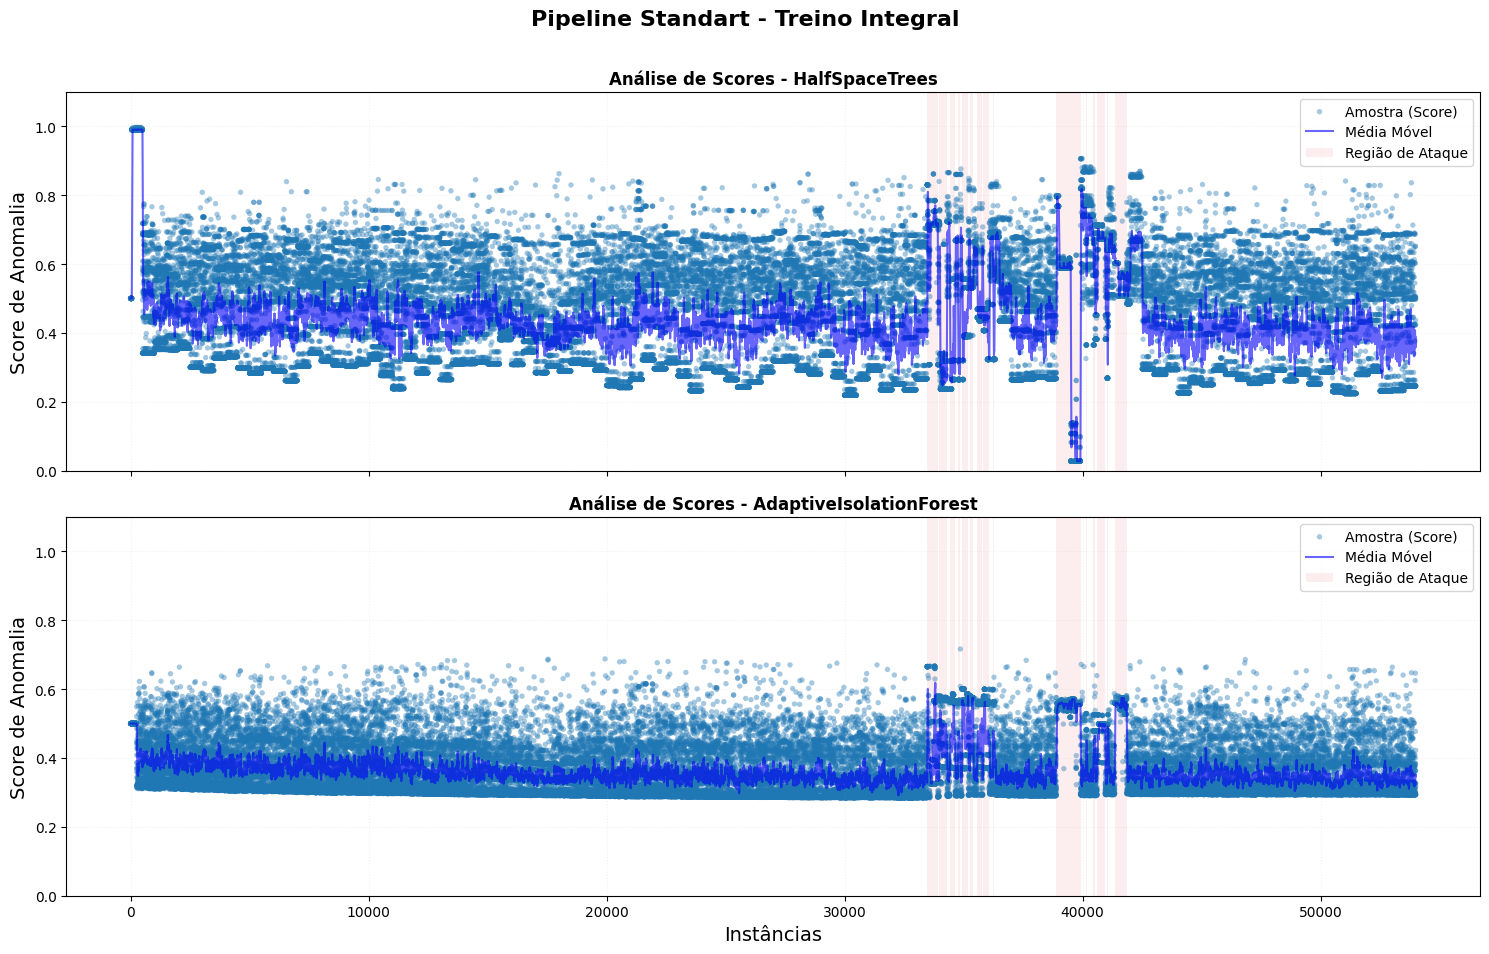

In [5]:
from py.AnomalyDetectionPipeline import AnomalyExperimentRunner
from py.AnomalyDetectionModels import get_anomaly_models
from py.DataStreamProcessor import DataStreamProcessor
import pandas as pd

# Instancia o objeto
processor = DataStreamProcessor(logging=True)
runner = AnomalyExperimentRunner()

df = pd.read_csv('datasets/CIC-IDS-2017/data/AnomalyDetection/DoS_Slowhttptest_slowloris.csv')

stream, targets, features = processor.create_stream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.001,
    threshold_corr=0.80,
    top_n_features=None,
    return_stream=True,
    extra_ignore_cols=['Source IP', 'Source Port','Destination IP','Destination Port','Protocol'],
    imputation_method='mediana'
)


# Configurar seus algoritmos 
algoritmos = get_anomaly_models(
    stream.get_schema(), 
    selected_models=['HST', 'AIF']
)

# Pipeline Padrão 
runner.ExecuteExperiments(
    stream=stream, 
    pipeline_name='standard', 
    algorithms=algoritmos,
    window_size=200, 
    title="Pipeline Standart - Treino Integral"
)

### Generalização

Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Unnamed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos...
Tratamento de Nulos: Preenchendo com a MEDIANA das colunas...
Normalização: MinMaxScaler
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 77) ---
Variância: 38 features removidas. Restantes: 39
Correlação (>0.8): 22 features redundantes removidas. Restantes: 17
Random Forest: Pular.
Features Finais (17) - ['Flow Duration', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Flow IAT Mean', 'Flow IAT Std', 'Fwd IAT Std', 'Bwd IAT Std', 'Fwd PSH Flags', 'Fwd Packets/s', 'FIN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward', 'Idle Std']
--- Fim do Processo de Seleção de Features ---

Finalização: Criando objet

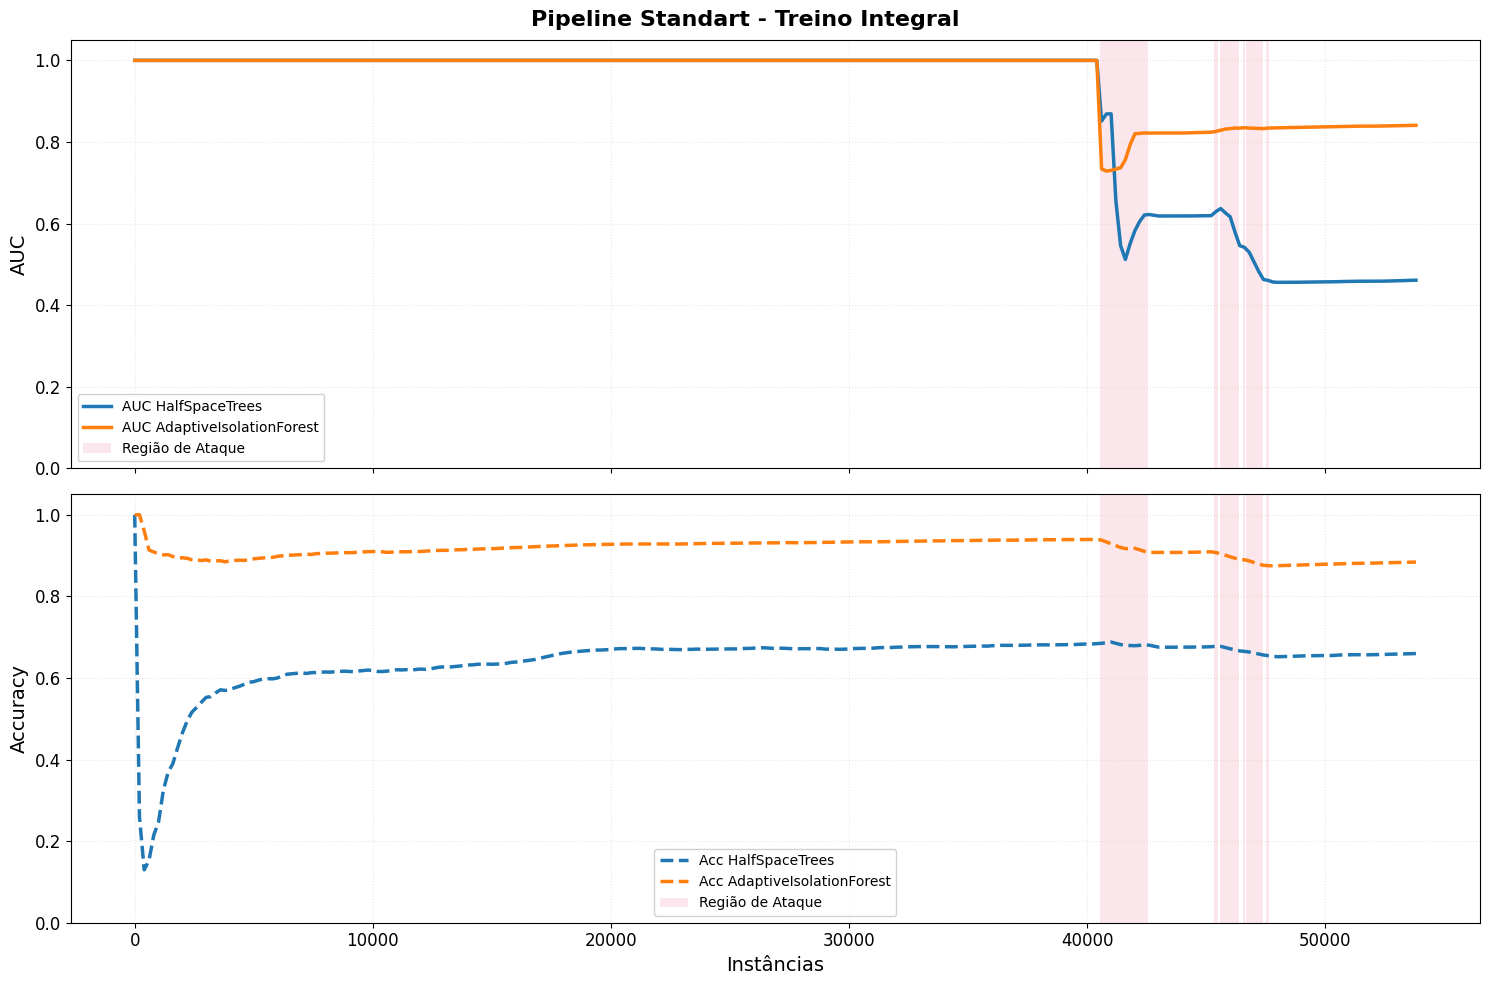

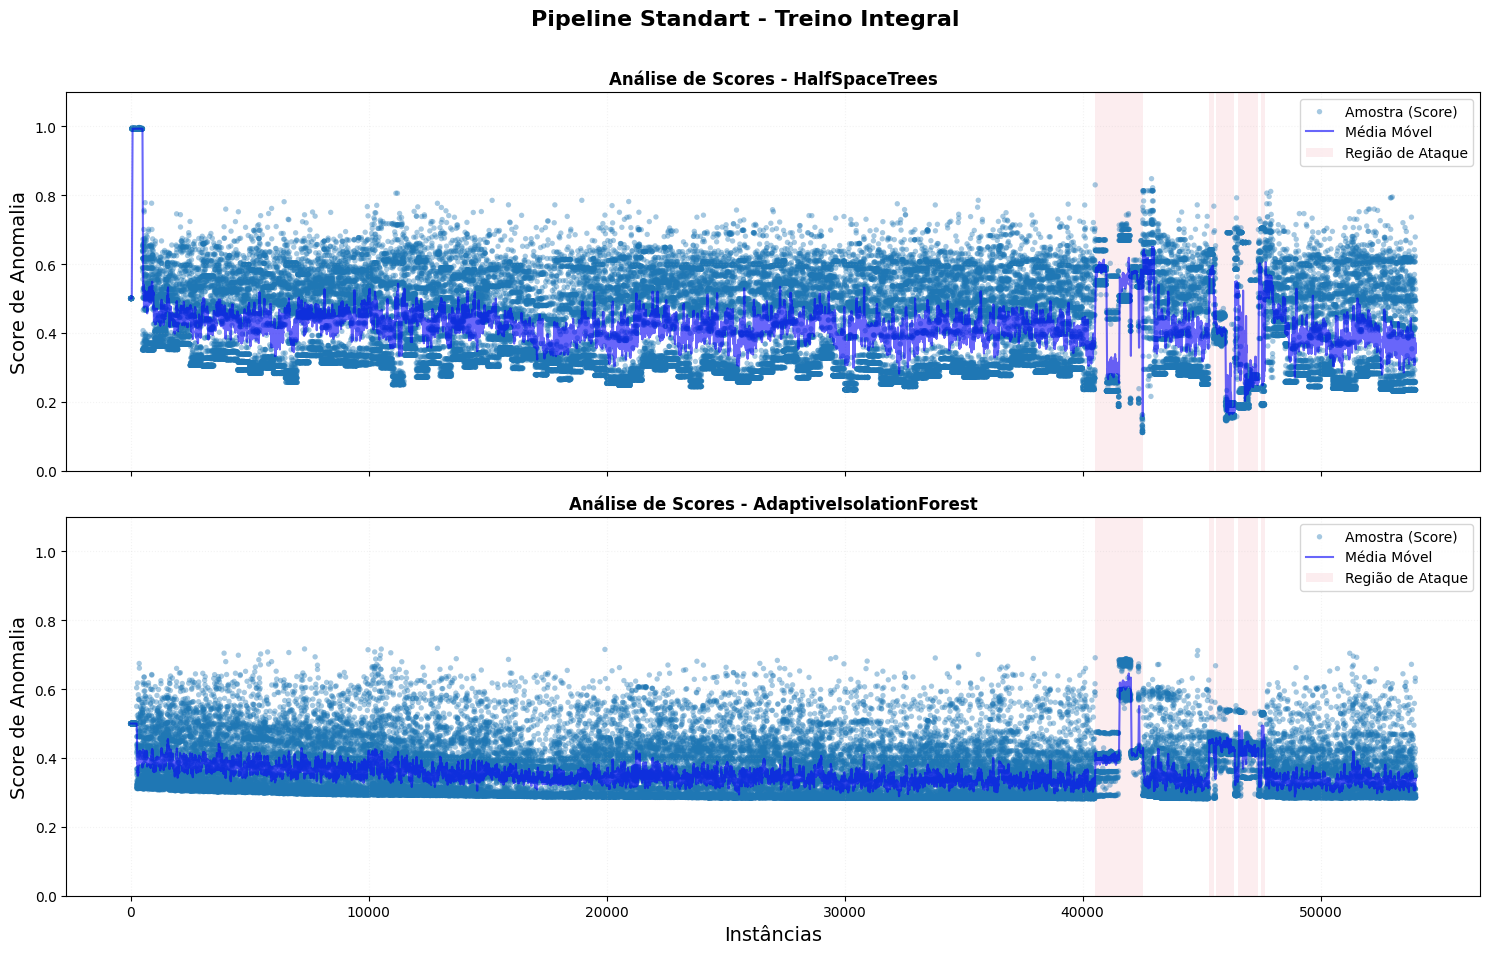

In [6]:
from py.AnomalyDetectionPipeline import AnomalyExperimentRunner
from py.AnomalyDetectionModels import get_anomaly_models
from py.DataStreamProcessor import DataStreamProcessor
import pandas as pd

# Instancia o objeto
processor = DataStreamProcessor(logging=True)
runner = AnomalyExperimentRunner()

df = pd.read_csv('datasets/CIC-IDS-2017/data/AnomalyDetection/DoS_GoldenEye_Hulk.csv')

stream, targets, features = processor.create_stream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.001,
    threshold_corr=0.80,
    top_n_features=None,
    return_stream=True,
    extra_ignore_cols=['Source IP', 'Source Port','Destination IP','Destination Port','Protocol'],
    imputation_method='mediana'
)


# Configurar seus algoritmos 
algoritmos = get_anomaly_models(
    stream.get_schema(), 
    selected_models=['HST', 'AIF']
)

# Pipeline Padrão 
runner.ExecuteExperiments(
    stream=stream, 
    pipeline_name='standard', 
    algorithms=algoritmos,
    window_size=200, 
    title="Pipeline Standart - Treino Integral"
)

### Adaptação

Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Unnamed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos...
Tratamento de Nulos: Preenchendo com a MEDIANA das colunas...
Normalização: MinMaxScaler
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 77) ---
Variância: 38 features removidas. Restantes: 39
Correlação (>0.8): 23 features redundantes removidas. Restantes: 16
Random Forest: Pular.
Features Finais (16) - ['Flow Duration', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Flow IAT Mean', 'Flow IAT Std', 'Fwd IAT Std', 'Fwd PSH Flags', 'Fwd Packets/s', 'FIN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward', 'Idle Std']
--- Fim do Processo de Seleção de Features ---

Finalização: Criando objeto NumpyStream p

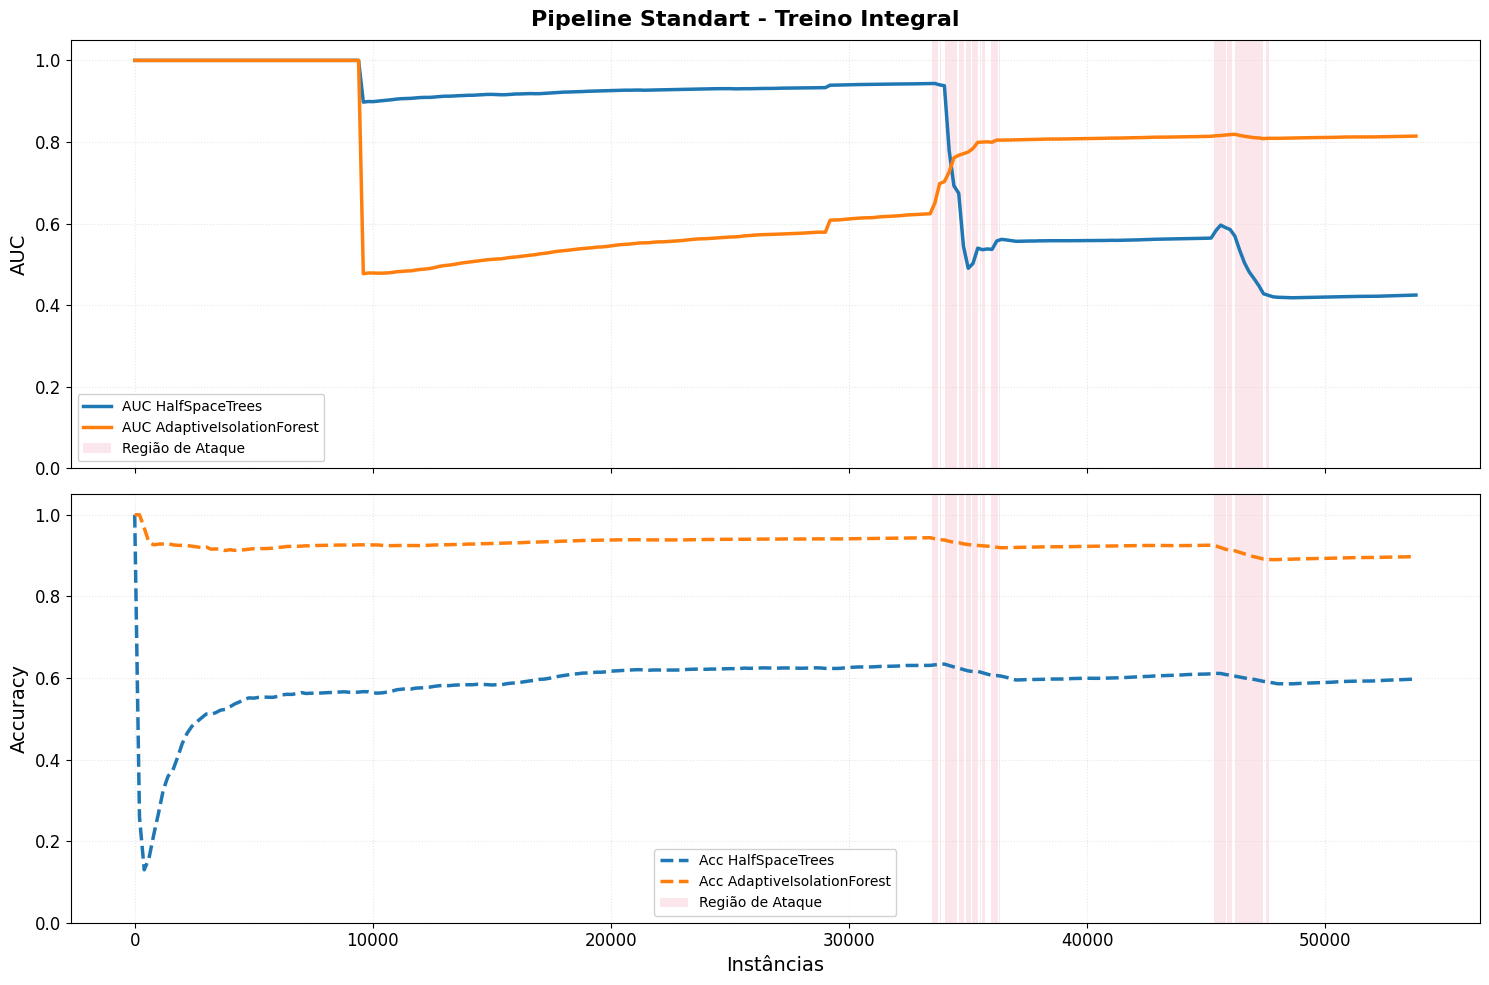

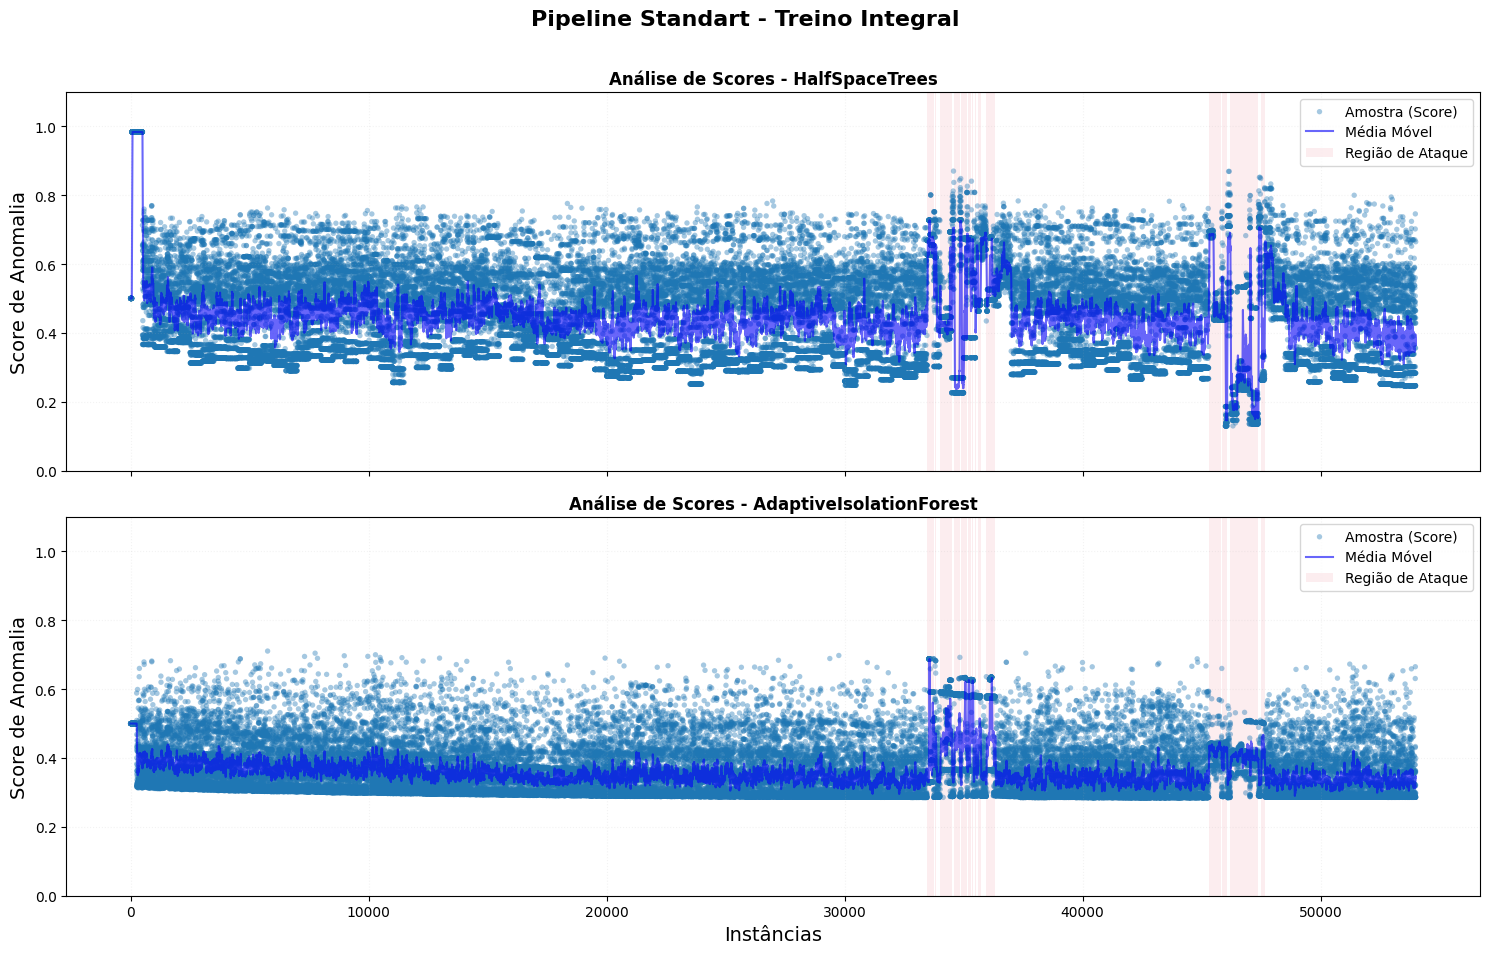

In [7]:
from py.AnomalyDetectionPipeline import AnomalyExperimentRunner
from py.AnomalyDetectionModels import get_anomaly_models
from py.DataStreamProcessor import DataStreamProcessor
import pandas as pd

# Instancia o objeto
processor = DataStreamProcessor(logging=True)
runner = AnomalyExperimentRunner()

df = pd.read_csv('datasets/CIC-IDS-2017/data/AnomalyDetection/DoS_slowloris_GoldenEye.csv')

stream, targets, features = processor.create_stream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.001,
    threshold_corr=0.80,
    top_n_features=None,
    return_stream=True,
    extra_ignore_cols=['Source IP', 'Source Port','Destination IP','Destination Port','Protocol'],
    imputation_method='mediana'
)


# Configurar seus algoritmos 
algoritmos = get_anomaly_models(
    stream.get_schema(), 
    selected_models=['HST', 'AIF']
)

# Pipeline Padrão 
runner.ExecuteExperiments(
    stream=stream, 
    pipeline_name='standard', 
    algorithms=algoritmos,
    window_size=200, 
    title="Pipeline Standart - Treino Integral"
)